In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, Birch, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df=pd.read_csv("data/processed/processed_transaction_data.csv")
df["TransactionTime"]=pd.to_datetime(df["TransactionTime"])

### Exploratory Data Analysis (EDA)

In [3]:
# DataFrame Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391282 entries, 0 to 391281
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   UserId                  391282 non-null  int64         
 1   TransactionId           391282 non-null  int64         
 2   TransactionTime         391282 non-null  datetime64[ns]
 3   ItemCode                391282 non-null  int64         
 4   ItemDescription         391282 non-null  object        
 5   NumberOfItemsPurchased  391282 non-null  int64         
 6   CostPerItem             391282 non-null  float64       
 7   Country                 391282 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 23.9+ MB


In [4]:
# Showing first 5 rows
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,2019-02-02 12:50:00,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,2018-12-26 09:06:00,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,2019-02-15 09:45:00,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,2018-06-22 07:14:00,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,285957,6307136,2019-01-11 09:50:00,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


In [5]:
# Summary Statistics
df.describe()

,UserId,TransactionId,TransactionTime,ItemCode,NumberOfItemsPurchased,CostPerItem
count,391282.000000,3.912820e+05,391282,3.912820e+05,391282.00000,3.912820e+05
mean,321191.320403,6.166531e+06,2018-10-01 20:11:15.253397760,6.459021e+05,39.52798,8.329293e+00
min,259266.000000,5.900015e+06,2018-02-12 04:26:00,4.200000e+01,3.00000,0.000000e+00
25%,293349.000000,6.041585e+06,2018-06-20 04:20:00,4.625670e+05,6.00000,1.730000e+00
50%,318297.000000,6.180636e+06,2018-10-13 07:23:00,4.759860e+05,18.00000,2.700000e+00
75%,352674.000000,6.292693e+06,2019-01-02 04:40:00,4.886700e+05,36.00000,5.180000e+00
max,384027.000000,6.397457e+06,2028-02-18 13:19:00,1.894494e+06,242985.00000,1.696285e+06
std,35913.396844,1.439571e+05,NaN,4.329260e+05,545.65348,2.711778e+03


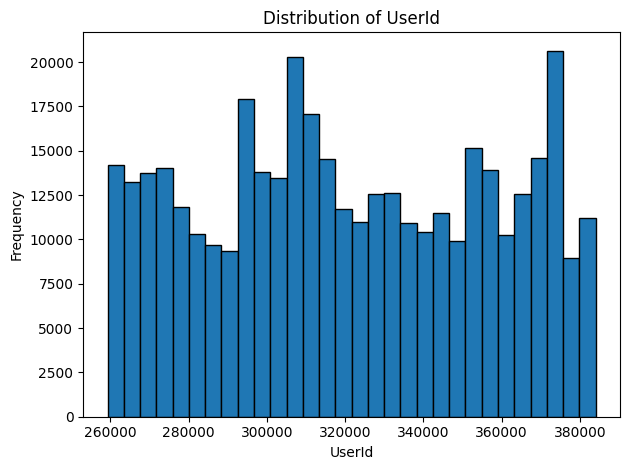

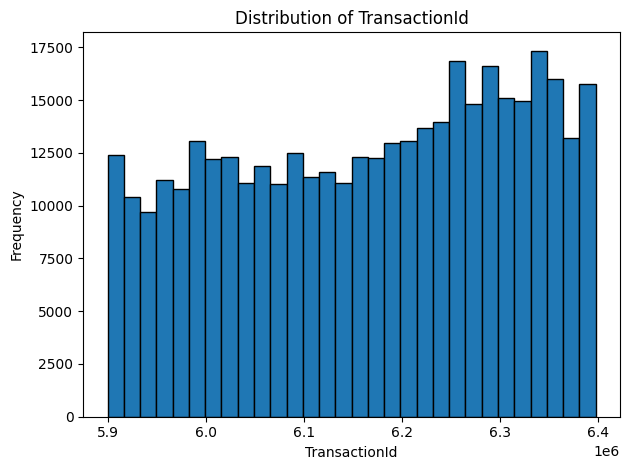

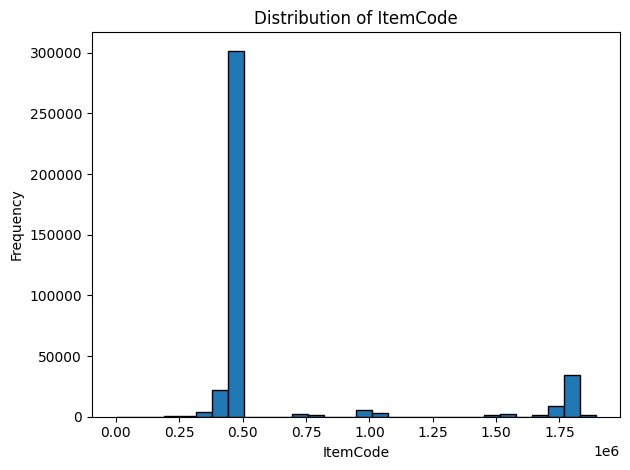

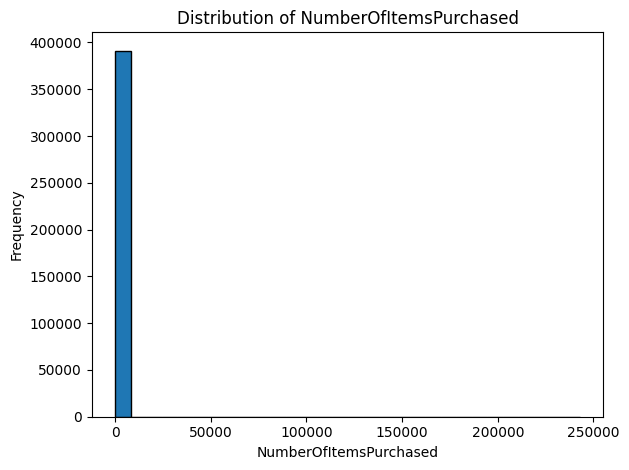

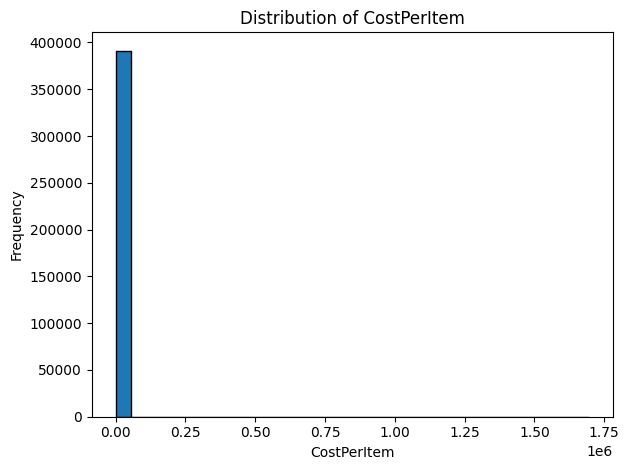

In [6]:
# Histogram Plot for Numeric Datatypes
numeric_cols=df.select_dtypes(include="number").columns
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col],bins=30,histtype="bar",edgecolor="black")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

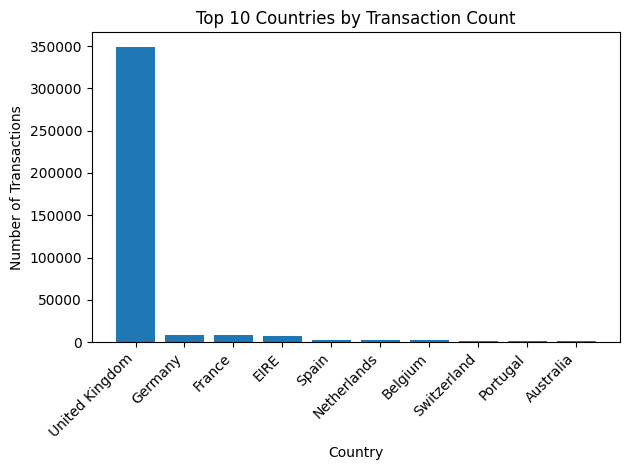

In [7]:
# Bar chart of top 10 countries by number of transactions
top_countries=df["Country"].value_counts().head(10)
plt.figure()
plt.bar(top_countries.index,top_countries.values)
plt.xticks(rotation=45,ha="right")
plt.xlabel("Country")
plt.ylabel("Number of Transactions")
plt.title("Top 10 Countries by Transaction Count")
plt.tight_layout()
plt.show()

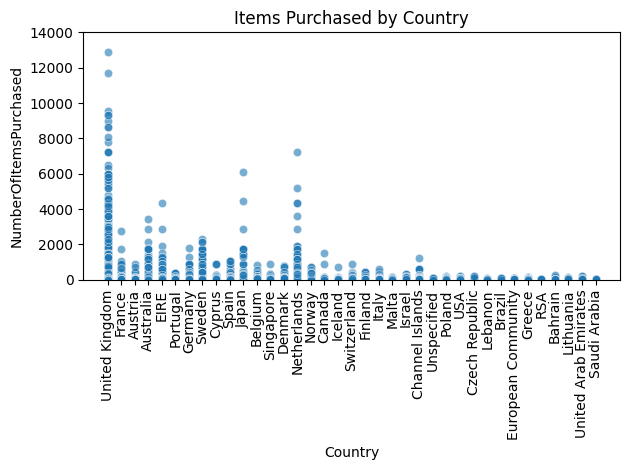

In [8]:
# Scatterplot of NumberOfItemsPurchased vs CostPerItem
plt.figure()
sns.scatterplot(data=df,x="Country",y="NumberOfItemsPurchased",alpha=0.6)
plt.ylim(0,14000)
plt.xticks(rotation=90)
plt.title("Items Purchased by Country")
plt.tight_layout()
plt.show()

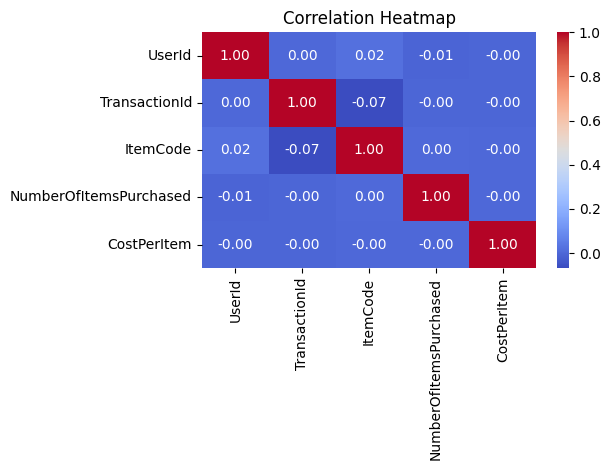

In [9]:
# Correlation Heatmap
corr=df.corr(numeric_only=True)
plt.figure()
sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

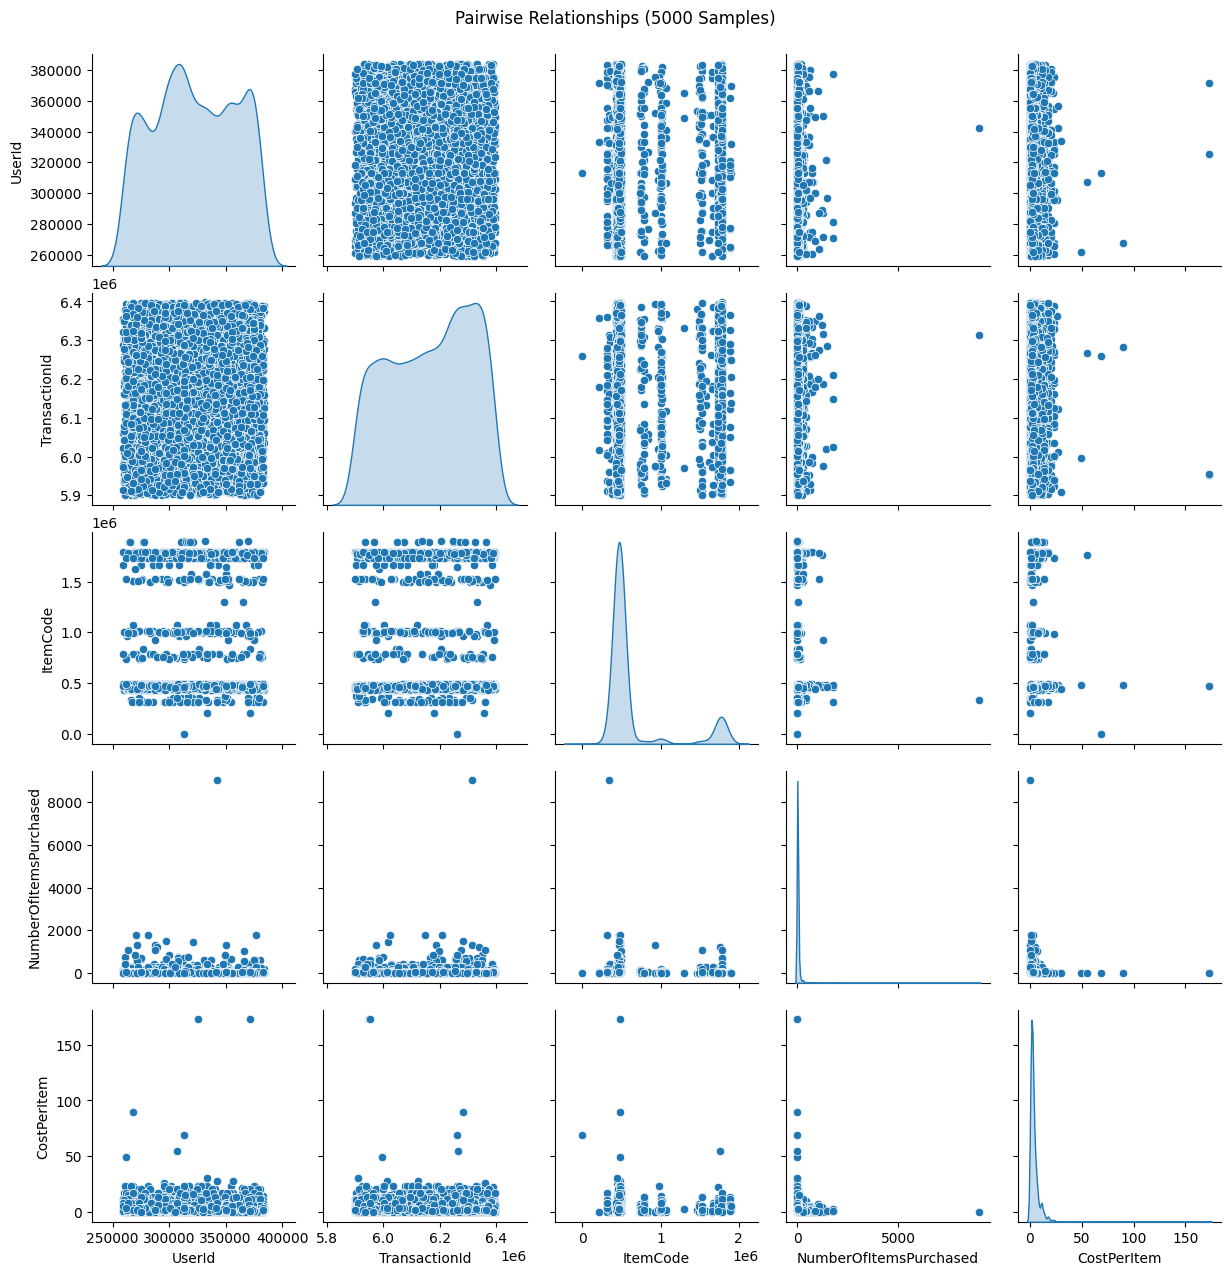

In [10]:
# Pairwise Relationships (5000 Samples)
sample=df[numeric_cols].sample(5000,random_state=42)
sns.pairplot(sample,diag_kind="kde")
plt.suptitle("Pairwise Relationships (5000 Samples)",y=1.02)
plt.show()

In [11]:
# Encoding categorical features
le=LabelEncoder()
for col in df.select_dtypes(include=["object"]).columns:
    df[col]=le.fit_transform(df[col])

In [12]:
# Building RFM table
# Recency: days since last transaction
today=df["TransactionTime"].max()+pd.Timedelta(days=1)
r_user=df.groupby("UserId")["TransactionTime"].max().reset_index()
r_user["Recency"]=(today-r_user["TransactionTime"]).dt.days

# Frequency: number of transactions
f_user=df.groupby("UserId")["TransactionId"].nunique().reset_index()
f_user.rename(columns={"TransactionId":"Frequency"},inplace=True)

# Monetary: total spend per user
df["Spend"]=df["NumberOfItemsPurchased"]*df["CostPerItem"]
m_user=df.groupby("UserId")["Spend"].sum().reset_index()
m_user.rename(columns={"Spend":"Monetary"},inplace=True)

# Computing RFM score
rfm=r_user.merge(f_user,on="UserId").merge(m_user,on="UserId")
rfm=rfm[["Recency","Frequency","Monetary"]]
rfm["RFM_Score"]=rfm.sum(axis=1)
print("Sample RFM scores:")
print(rfm.head(),"\n")

Sample RFM scores:
   Recency  Frequency   Monetary  RFM_Score
0     3611          1  320608.80  324220.80
1        1          7   17879.70   17887.70
2     3361          4    5991.12    9356.12
3     3304          1    6043.92    9348.92
4     3596          1    1221.60    4818.60 



In [13]:
# Feature scaling
scaler_std=StandardScaler()
X_std=scaler_std.fit_transform(rfm)

In [14]:
# Dimensionality Reduction
# PCA (retain 3 components)
pca=PCA(n_components=3,random_state=42)
X_pca=pca.fit_transform(X_std)
print("Explained variance ratio per PC:",pca.explained_variance_ratio_,"\n")

Explained variance ratio per PC: [0.50035635 0.30566038 0.19398327] 



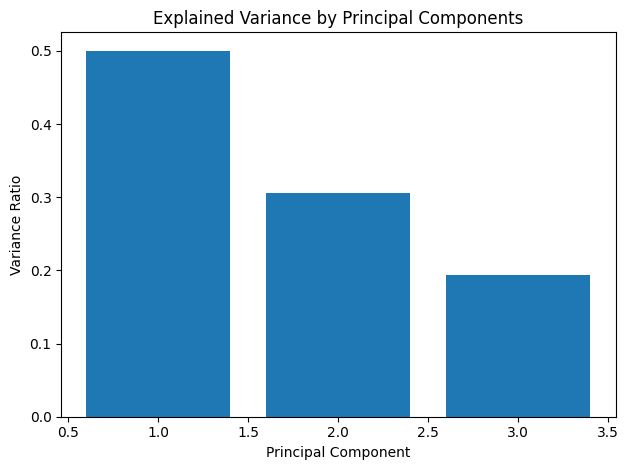

In [15]:
# Ploting explained variance
plt.figure()
plt.bar(range(1,4),pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.tight_layout()
plt.show()

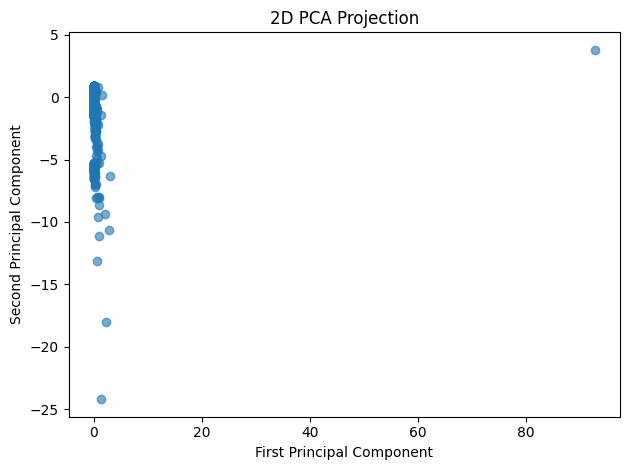

In [16]:
# 2D PCA projection
plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("2D PCA Projection")
plt.tight_layout()
plt.show()

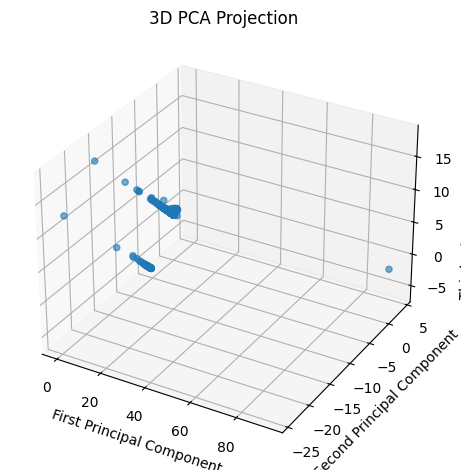

In [17]:
# 3D PCA projection
fig=plt.figure()
ax=fig.add_subplot(111,projection="3d")
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],alpha=0.6)
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
ax.set_title("3D PCA Projection")
plt.tight_layout()
plt.show()

Executing t-SNE:


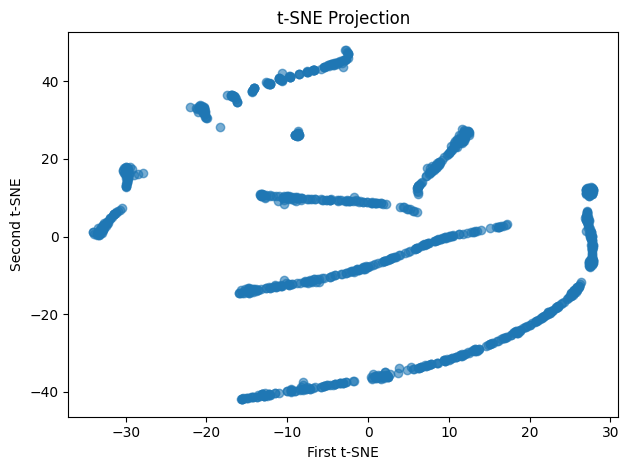

In [18]:
# t-SNE (sample if large)
if X_std.shape[0]>1000:
    idx=np.random.choice(X_std.shape[0],1000,replace=False)
    X_tsne_input=X_std[idx]
else:
    X_tsne_input=X_std
print("Executing t-SNE:")
X_tsne=TSNE(n_components=2,random_state=42).fit_transform(X_tsne_input)
plt.figure()
plt.scatter(X_tsne[:,0],X_tsne[:,1],alpha=0.6)
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()

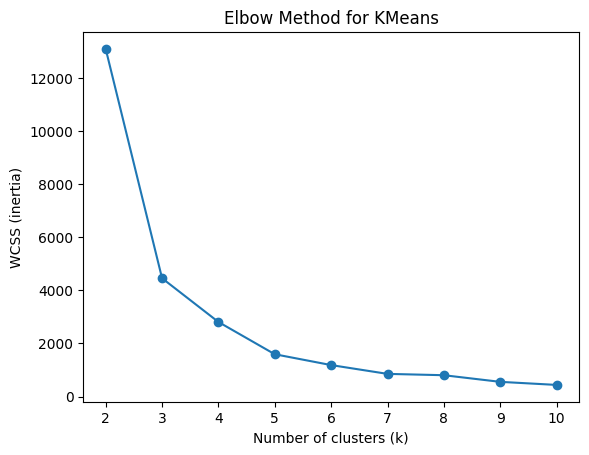

In [19]:
# Clustering Pipeline
# Elbow method for KMeans
wcss=[]
for k in range(2,11):
    km=KMeans(n_clusters=k,random_state=42).fit(X_std)
    wcss.append(km.inertia_)
plt.figure()
plt.plot(range(2,11),wcss,marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (inertia)")
plt.title("Elbow Method for KMeans")
plt.show()

In [20]:
# Estimating MeanShift bandwidth based on quantile
bw=estimate_bandwidth(X_std,quantile=0.9835,random_state=42)

# Estimating DBSCAN eps via k-distance (k=5) and 90th percentile knee
nbrs=NearestNeighbors(n_neighbors=5).fit(X_std)
distances,_=nbrs.kneighbors(X_std)
sorted_dist=np.sort(distances[:,-1])
eps_est=np.percentile(sorted_dist,97.75)

# Estimating BIRCH threshold as 50th percentile of pairwise distances
pdists=pairwise_distances(X_std)
thresh=np.percentile(pdists,25)

In [21]:
# Defining clustering models
cluster_models={
    "KMeans": lambda: KMeans(n_clusters=4,random_state=42),
    "MeanShift": lambda: MeanShift(bandwidth=bw),
    "DBSCAN": lambda: DBSCAN(eps=eps_est,min_samples=5),
    "Hierarchical": lambda: AgglomerativeClustering(n_clusters=4,linkage="ward"),
    "GMM": lambda: GaussianMixture(n_components=4,covariance_type="full",random_state=42),
    "BIRCH": lambda: Birch(n_clusters=4,threshold=thresh)
}

Executing KMeans


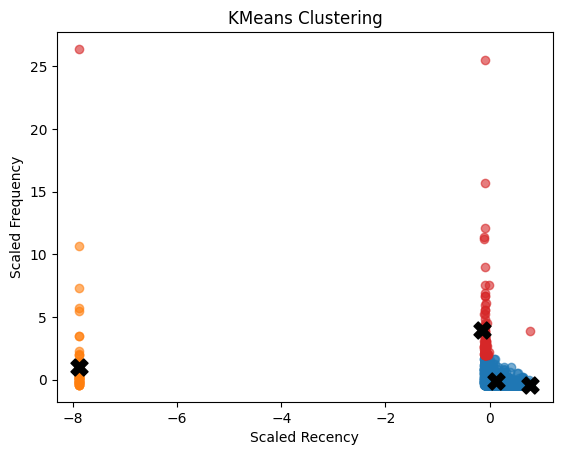

Cluster Summary for KMeans:
             Recency  Frequency      Monetary     RFM_Score
Cluster                                                    
0        3380.585436   3.333814  5.600975e+03  8.984894e+03
1           1.000000  11.859375  5.344659e+04  5.345945e+04
2        3659.000000   1.000000  4.071085e+07  4.071451e+07
3        3265.486239  34.642202  8.763108e+04  9.093121e+04 

Executing MeanShift


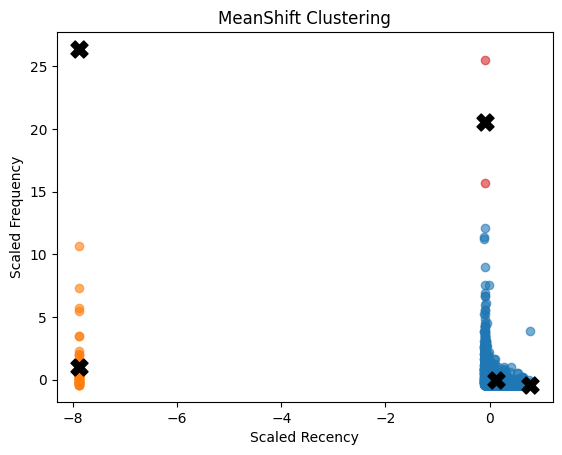

Cluster Summary for MeanShift:
             Recency   Frequency      Monetary     RFM_Score
Cluster                                                     
0        3378.481134    4.011952  7.493765e+03  1.087626e+04
1           1.000000   11.859375  5.344659e+04  5.345945e+04
2        3659.000000    1.000000  4.071085e+07  4.071451e+07
3        3287.000000  161.500000  3.751058e+05  3.785543e+05
4           1.000000  206.000000  1.313372e+05  1.315442e+05 

Executing DBSCAN


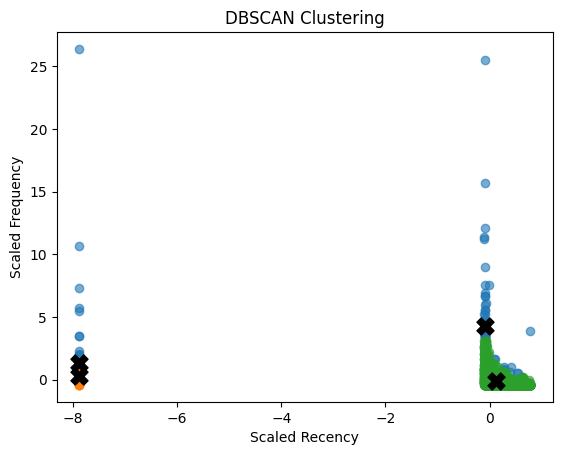

Cluster Summary for DBSCAN:
             Recency  Frequency      Monetary     RFM_Score
Cluster                                                    
0           1.000000   6.204082   8718.574898   8725.778980
1        3379.056599   3.596195   5517.432549   8900.085344
2        3289.200000  36.800000  46096.920000  49422.920000
3           1.000000  14.600000  18929.766000  18945.366000 

Executing Hierarchical


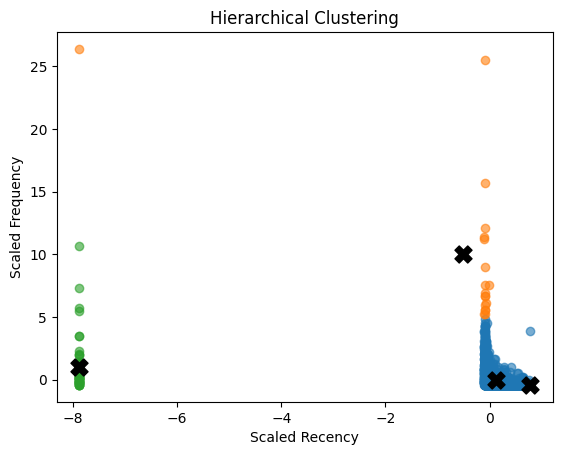

Cluster Summary for Hierarchical:
             Recency  Frequency      Monetary     RFM_Score
Cluster                                                    
0        3378.785278   3.808561  6.602291e+03  9.984885e+03
1        3108.833333  80.777778  2.658058e+05  2.689954e+05
2           1.000000  11.859375  5.344659e+04  5.345945e+04
3        3659.000000   1.000000  4.071085e+07  4.071451e+07 

Executing GMM


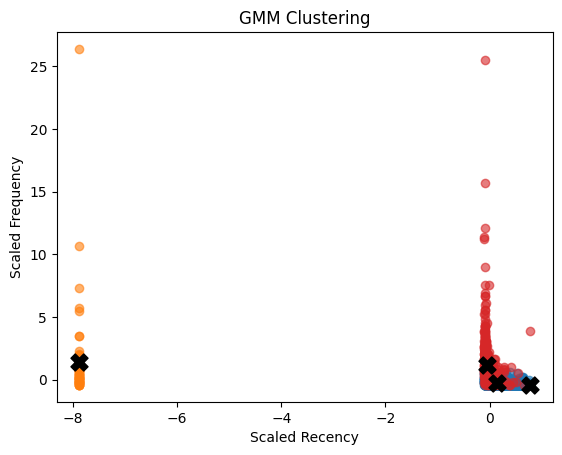

Cluster Summary for GMM:
             Recency  Frequency      Monetary     RFM_Score
Cluster                                                    
0        3390.251721   2.462682  3.147692e+03  6.540407e+03
1           1.000000  14.846154  5.464490e+04  5.466075e+04
2        3659.000000   1.000000  4.071085e+07  4.071451e+07
3        3311.205329  13.322884  3.338062e+04  3.670515e+04 

Executing BIRCH


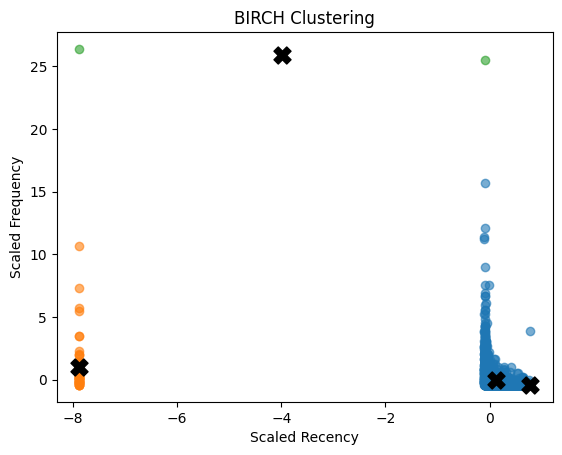

Cluster Summary for BIRCH:
           Recency   Frequency      Monetary     RFM_Score
Cluster                                                   
0        3378.4597    4.040066  7.531366e+03  1.091387e+04
1           1.0000   11.859375  5.344659e+04  5.345945e+04
2        1644.0000  202.500000  3.567875e+05  3.586340e+05
3        3659.0000    1.000000  4.071085e+07  4.071451e+07 



In [22]:
# Fitting, ploting, and evaluating each clustering model
evaluation=[]
for name, ctor in cluster_models.items():
    print(f"Executing {name}")
    model=ctor() if callable(ctor) else ctor
    labels=model.fit_predict(X_std)

    # Computing centroids per cluster
    unique_labels=np.unique(labels)
    centroids=np.array([X_std[labels==lbl].mean(axis=0) for lbl in unique_labels if lbl!=-1])

    # 2D scatter on first two scaled RFM features
    plt.figure()
    for lbl in unique_labels:
        mask=(labels==lbl)
        plt.scatter(X_std[mask,0],X_std[mask,1],label=f"Cluster {lbl}",alpha=0.6)
    plt.scatter(centroids[:,0],centroids[:,1],marker="X",s=150,c="black",label="Centroids")
    plt.xlabel("Scaled Recency")
    plt.ylabel("Scaled Frequency")
    plt.title(f"{name} Clustering")
    plt.show()

    # Evaluation metrics
    sil=silhouette_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    db=davies_bouldin_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    ch=calinski_harabasz_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    inertia=getattr(model,"inertia_",np.nan)
    evaluation.append({"Algorithm":name,"Silhouette":sil,"Davies-Bouldin":db,"Calinski-Harabasz":ch,"WCSS":inertia})

    # Cluster summary (using RFM)
    rfm_with_labels=rfm.copy()
    rfm_with_labels["Cluster"]=labels
    summary=rfm_with_labels[rfm_with_labels["Cluster"]!=-1].groupby("Cluster").mean()
    print(f"Cluster Summary for {name}:")
    print(summary,"\n")

In [23]:
results_df=pd.DataFrame(evaluation)
print("Clustering Evaluation Metrics:")
print(results_df,"\n")

Clustering Evaluation Metrics:
      Algorithm  Silhouette  Davies-Bouldin  Calinski-Harabasz         WCSS
0        KMeans    0.846806        0.406236        7467.992074  2809.037097
1     MeanShift    0.915187        0.323355        5193.355468          NaN
2        DBSCAN    0.843724        0.273459        3708.543114          NaN
3  Hierarchical    0.917235        0.407444        7588.377829          NaN
4           GMM    0.613558        0.532527        6008.287613          NaN
5         BIRCH    0.915255        0.164016        6330.280303          NaN 



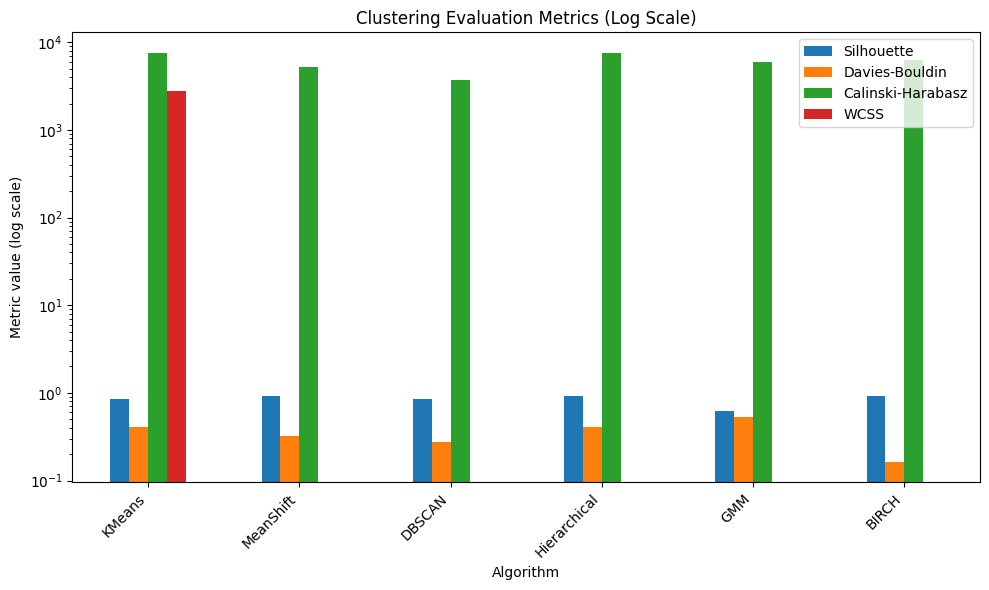

In [24]:
# Plot evaluation metrics
plot_df=results_df.set_index("Algorithm")
plot_df.plot(kind="bar",logy=True,figsize=(10,6))
plt.title("Clustering Evaluation Metrics (Log Scale)")
plt.ylabel("Metric value (log scale)")
plt.xlabel("Algorithm")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [25]:
# Selecting best algorithm
results_df["rank_sil"]=results_df["Silhouette"].rank(ascending=False)
results_df["rank_db"]=results_df["Davies-Bouldin"].rank(ascending=True)
results_df["rank_ch"]=results_df["Calinski-Harabasz"].rank(ascending=False)
if results_df["WCSS"].dropna().empty:
    results_df["rank_wcss"]=np.nan
else:
    results_df["rank_wcss"]=results_df["WCSS"].rank(ascending=True)
results_df["rank_sum"]=results_df[["rank_sil","rank_db","rank_ch","rank_wcss"]].sum(axis=1,skipna=True)
best_row=results_df.loc[results_df["rank_sum"].idxmin()]
best_algo=best_row["Algorithm"]
print(f"Best algorithm:{best_algo}\n")

Best algorithm:BIRCH



In [26]:
# Assigning final cluster labels
best_model=cluster_models[best_algo]()
best_labels=best_model.fit_predict(X_std)
user_cluster_map=rfm.copy()
user_cluster_map["Cluster"]=best_labels
if "UserId" not in user_cluster_map.columns:
    user_cluster_map=user_cluster_map.reset_index()
    if "UserId" not in user_cluster_map.columns:
         user_cluster_map=user_cluster_map.merge(r_user[["UserId"]].reset_index(),left_index=True,right_index=True)
         user_cluster_map = user_cluster_map.drop(columns=["index_x","index_y"])
if "Cluster" in df.columns:
    df=df.drop("Cluster",axis=1)
df=df.merge(user_cluster_map,on="UserId",how="left")

In [27]:
# Final profiling using the best algorithm labels
final_profile=df.groupby("Cluster").mean(numeric_only=True)
print(f"Final Cluster Profile (by {best_algo} Algorithm):")
print(final_profile)

Final Cluster Profile (by BIRCH Algorithm):
                UserId  TransactionId       ItemCode  ItemDescription  \
Cluster                                                                 
0        321536.955386   6.166851e+06  646080.128819      2011.695370   
1        333848.313026   6.130890e+06  646185.286280      2007.856612   
2        293291.432006   6.197721e+06  639053.732691      1992.776199   
3        288687.000000   5.900323e+06  465780.000000      2801.000000   

         NumberOfItemsPurchased   CostPerItem    Country         Spend  \
Cluster                                                                  
0                     38.156724  3.977467e+00  33.203980  8.708716e+01   
1                     88.022041  4.029208e+00  32.609708  2.823660e+02   
2                     31.450978  4.561853e+00  20.919340  7.088258e+01   
3                     24.000000  1.696285e+06  35.000000  4.071085e+07   

             Recency   Frequency      Monetary     RFM_Score  
Cluster  